<h1 align="center"><img src="https://isif-ostewg.org/favicon.ico"><br>Open Source Tracking and State Estimation Working Group</h1>
<h2 align="center"><a href="https://isif-ostewg.org/resources/#ostewg-focus-topics" target="blank">2019 Focus Topic: Simulated WAMI data set</a></h2>
<h4 align="center">Code License: MIT, Dstl © Crown Copyright, 2019</h4>

The chosen _Focus Topic_ for 2019 (spanning the year between <a href="https://www.fusion2019.org/">Fusion 2019</a> and <a href="http://www.fusion2020.org/">Fusion 2020</a>) is the _Simulated <abbr title="Wide Area Motion Imagery">WAMI</abbr> data set_, offered by the <a href="https://www.liverpool.ac.uk/">University of Liverpool</a>. This data set exhibits an interesting set of technical challenges such as very large numbers of targets, obscuration resulting in missed detections and some challenging association problems. For a link to the Trello board for this Focus Topic, please email contact@isif-ostewg.org.

In [1]:
# Some general imports and set up
import matplotlib
%matplotlib inline

from matplotlib import pyplot as plt
from matplotlib.lines import Line2D

from datetime import timedelta, datetime
from itertools import cycle

import numpy as np

# Reading the ground truth

First we'll read the ground truth data from _truth.txt_ file provided. The format used here isn't a standard csv format, but it's close enough that we can make it work. We'll read the data in and then plot the states, colouring by _ground truth path_.

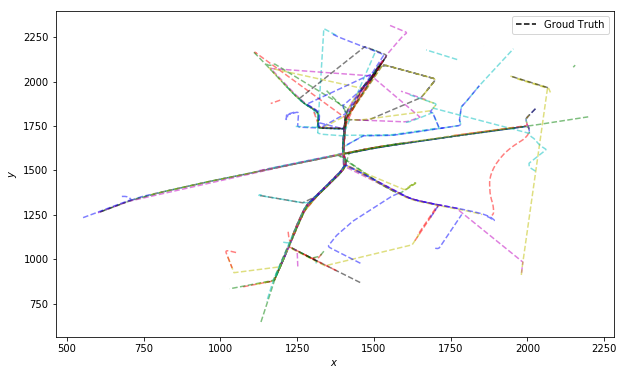

In [2]:
from csv import Dialect, QUOTE_NONE

from stonesoup.reader.generic import CSVGroundTruthReader

class UoLWAMIDataDialect(Dialect):
    delimiter=' '
    skipinitialspace=True
    quoting=QUOTE_NONE
    lineterminator='\r\n'

truth_detections = CSVGroundTruthReader(
    "truth.txt",
    state_vector_fields=("x", "y"),
    time_field="time",
    timestamp=True,
    path_id_field="id",
    csv_options={'dialect': UoLWAMIDataDialect,
                 'fieldnames': ['time', 'x', 'y', 'id']})

groundtruth_paths = set()
for _, paths in truth_detections.groundtruth_paths_gen():
    groundtruth_paths.update(paths)

color_loop = iter(cycle(["b","g","r","c","m","y","k"]))

#Plot the result
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
plt.rcParams['figure.figsize'] = [10, 10]
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")

for path in groundtruth_paths:
    plt.plot([state.state_vector[0, 0] for state in path], 
             [state.state_vector[1, 0] for state in path],
             c=next(color_loop), alpha=0.5, linestyle='--')
ax.legend((Line2D([0], [0], c='k', linestyle='--'),), ("Groud Truth", ))

# Reading the detections

Now we have the ground truth, let's plot the detections in the same way.

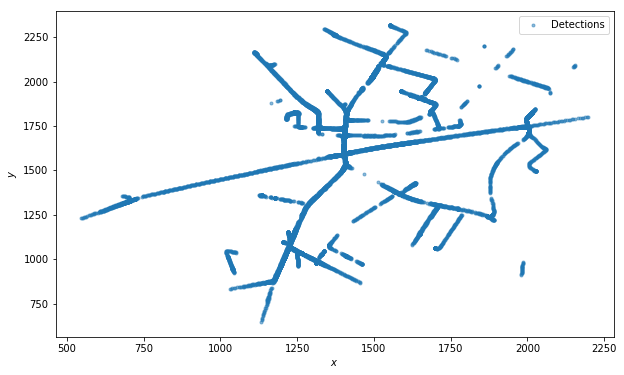

In [3]:
from stonesoup.reader.generic import CSVDetectionReader
detector = CSVDetectionReader(
    "detections.txt",
    state_vector_fields=("x", "y"),
    time_field="time",
    timestamp=True,
    csv_options={'dialect': UoLWAMIDataDialect,
                 'fieldnames': ['time', 'x', 'y']})

detections = set()
for _, detection in detector.detections_gen():
    detections.update(detection) 

#Plot the result
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")

plt.scatter([state.state_vector[0, 0] for state in detections], 
            [state.state_vector[1, 0] for state in detections],
            marker='.', alpha=0.5, label="Detections")
ax.legend()

We'll overlay the two plots, just to verify data matches the ground truth.

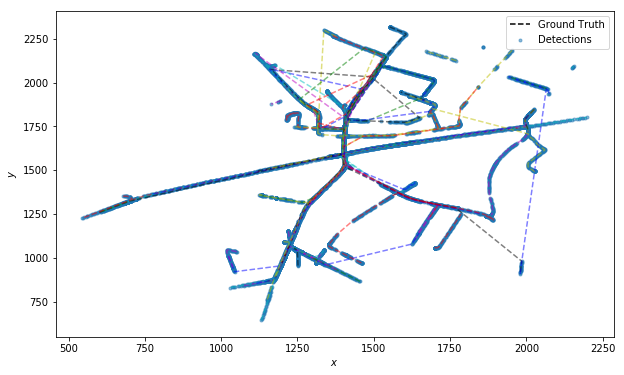

In [4]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")

for path in groundtruth_paths:
    plt.plot([state.state_vector[0, 0] for state in path], 
             [state.state_vector[1, 0] for state in path],
             c=next(color_loop), alpha=0.5, linestyle='--',
             )
det_scatter = plt.scatter(
    [state.state_vector[0, 0] for state in detections], 
    [state.state_vector[1, 0] for state in detections],
    marker='.', alpha=0.5)
ax.legend((Line2D([0], [0], c='k', linestyle='--'), det_scatter), ("Ground Truth", "Detections" ))

# Building our basic tracker

We'll start by building a very simple tracker. This may not track very well, but this is expected as we hope OSTEWG participating members will develop better trackers as part of the collaboration.

In [5]:
from stonesoup.models.transition.linear import CombinedLinearGaussianTransitionModel,\
                                               ConstantVelocity
transition_model = CombinedLinearGaussianTransitionModel(
    (ConstantVelocity(1), ConstantVelocity(1)))

from stonesoup.models.measurement.linear import LinearGaussian
measurement_model = LinearGaussian(
    ndim_state=4, mapping=[0, 2], noise_covar=np.diag([10, 10]))

from stonesoup.predictor.kalman import KalmanPredictor
predictor = KalmanPredictor(transition_model)

from stonesoup.updater.kalman import KalmanUpdater
updater = KalmanUpdater(measurement_model)

from stonesoup.measures import Mahalanobis

from stonesoup.hypothesiser.distance import DistanceHypothesiser
hypothesiser = DistanceHypothesiser(
    predictor, updater, Mahalanobis(), missed_distance=3)

from stonesoup.dataassociator.neighbour import NearestNeighbour
data_associator = NearestNeighbour(hypothesiser)

from stonesoup.initiator.simple import LinearMeasurementInitiator
from stonesoup.types.state import GaussianState

initiator = LinearMeasurementInitiator(
    GaussianState(np.array([[0], [0], [0], [0]]), np.diag([0, 1, 0, 1])),
    measurement_model=measurement_model)

from stonesoup.deleter.error import CovarianceBasedDeleter
deleter = CovarianceBasedDeleter(covar_trace_thresh=500)

# Used so detections at same time stamp are together
# Data in steps of 0.2 seconds
from stonesoup.feeder.time import TimeSyncFeeder
sync_detector = TimeSyncFeeder(detector, timedelta(microseconds=2E5))

from stonesoup.tracker.simple import MultiTargetTracker
tracker = MultiTargetTracker(
    initiator=initiator,
    deleter=deleter,
    detector=sync_detector,
    data_associator=data_associator,
    updater=updater,
)

We'll now run the tracker. This may take a while, so you may wish to interupt the execution.

In [6]:
try:
    tracks = set()
    for step, (time, ctracks) in enumerate(tracker.tracks_gen(), 1):
        tracks.update(ctracks)
        if not step % 100:
            print("Step: {} Time: {}".format(step, time))
except KeyboardInterrupt:
    # Interupt the kernel to skip running the whole tracker.
    pass
finally:
    last_track_time = time
    if step in locals():
        print("Step: {} Time: {}".format(step, time))

Step: 100 Time: 1970-01-01 00:00:19.800000
Step: 200 Time: 1970-01-01 00:00:39.800000
Step: 300 Time: 1970-01-01 00:00:59.800000
Step: 400 Time: 1970-01-01 00:01:19.800000
Step: 500 Time: 1970-01-01 00:01:39.800000
Step: 600 Time: 1970-01-01 00:01:59.800000
Step: 700 Time: 1970-01-01 00:02:19.800000
Step: 800 Time: 1970-01-01 00:02:39.800000
Step: 900 Time: 1970-01-01 00:02:59.800000
Step: 1000 Time: 1970-01-01 00:03:19.800000
Step: 1100 Time: 1970-01-01 00:03:39.800000
Step: 1200 Time: 1970-01-01 00:03:59.800000
Step: 1300 Time: 1970-01-01 00:04:19.800000
Step: 1400 Time: 1970-01-01 00:04:39.800000
Step: 1500 Time: 1970-01-01 00:04:59.800000


# The results

Now the tracker has been run, let's plot the results of the tracks in $x$ and $y$

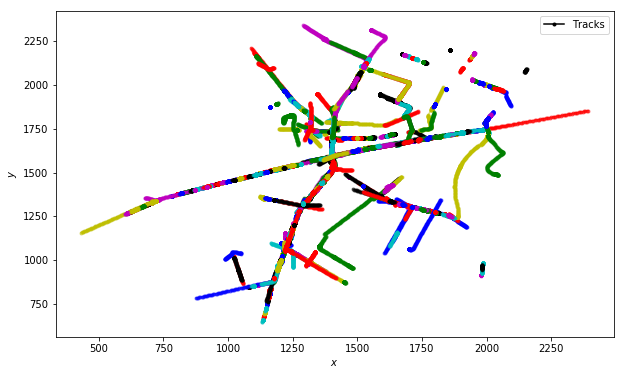

In [7]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
plt.rcParams['figure.figsize'] = [10, 10]
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")

#Plot the result
for track in tracks:
    plt.plot([state.state_vector[0, 0] for state in track], 
             [state.state_vector[2, 0] for state in track],
             c=next(color_loop), alpha=0.5, marker='.')
ax.legend((Line2D([0], [0], c='k', marker='.'),), ("Tracks", ))

We'll now plot both the track and ground truth data together.

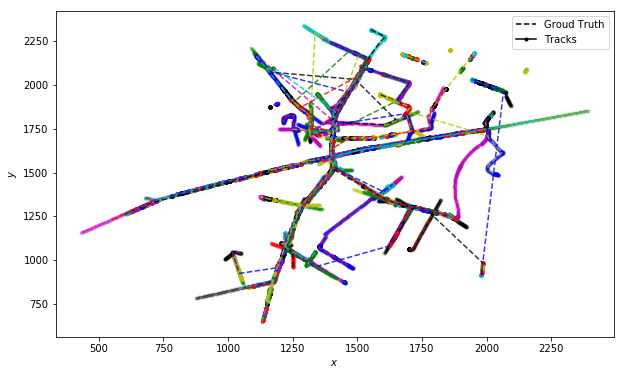

In [8]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
plt.rcParams['figure.figsize'] = [10, 10]
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")

#Plot the result
for track in tracks:
    plt.plot([state.state_vector[0, 0] for state in track], 
             [state.state_vector[2, 0] for state in track],
             c=next(color_loop), alpha=0.2, marker='.')

for path in groundtruth_paths:
    # Let's only plot ground truth for period that tracker was run.
    state_vectors = np.array([state.state_vector
                               for state in path
                               if state.timestamp <= last_track_time])
    if state_vectors.any():
        plt.plot(state_vectors[:, 0], 
                 state_vectors[:, 1],
                 c=next(color_loop), alpha=0.8, linestyle='--')
ax.legend(
    (Line2D([0], [0], c='k', linestyle='--'), Line2D([0], [0], c='k', marker='.')),
    ("Groud Truth", "Tracks"))

Let's zoom in on one area

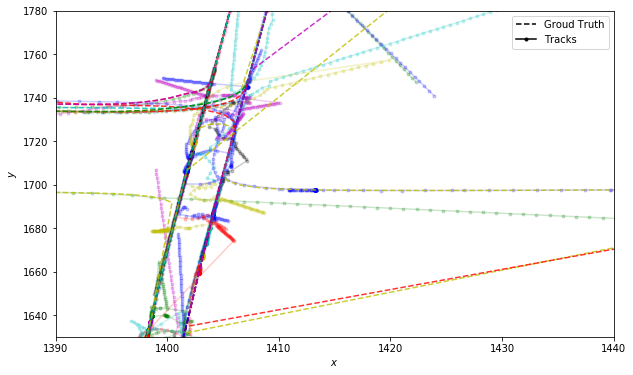

In [9]:
ax.set_xlim(1390, 1440)
ax.set_ylim(1630, 1780)
fig

Let's look at generating some basic metrics. As we expect this to track very poorly, we'll just use the basic metrics, but elements are in place here for OSPA and SIAP metrics for later.

In [10]:

# This is needed just for mapping sgroundtruth to measurement space in metrics
from stonesoup.models.measurement.linear import LinearGaussian
groudtruth_measurement_model = LinearGaussian(
    ndim_state=2, mapping=[0, 1], noise_covar=None)

from stonesoup.metricgenerator.basicmetrics import BasicMetrics
basic_calculator = BasicMetrics()

from stonesoup.metricgenerator.manager import SimpleManager
metric_manager = SimpleManager([basic_calculator], associator=None)
metric_manager.add_data([tracks, groundtruth_paths, detections])

In [11]:
metrics = metric_manager.generate_metrics()
for metric in metrics:
    print(metric.title,":", metric.value)

Number of tracks : 587
Track-to-target ratio : 5.87
Number of targets : 100
